<h1 style="text-align:center">
    Madrid accidents statistics: Some doodling with Python and the Pandas, Matplotlib and Numpy libraries.
</h1>

<br>

<font color="darkblue">

<h3 style="text-align:center">
    Javier Eloy Martínez Ramos
</h3>
    
<h3 style="text-align:center">
    January 18, 2022
</h3>

<hr>

## Introduction

<font color="darkblue"> In this project, we perform some basic data analysis in Python about the traffic accidents in the Madrid Community since 2019. The data comes from a database by the Madrid Municipal Police available in the spanish National Institute of Statistics website. (INE)

## a) Some simple operations

**Rounding the hour**

First we are going to round the hour variable, ignoring the minutes and keeping only the hour int, between 0 and 23.

In [3]:
def redondeo_hora(hora):
    return hora.split(":")[0]


In [4]:
# Tests:

print(redondeo_hora('12:48'))

12


We want to make several tests:

In [5]:
# Tests:

for h in ['15:00', '23:15', '14:22']:
    print(redondeo_hora(h))

15
23
14


**Age ranges**

Now, we want to codify the age ranges, asigning each range a two int interval.
For the 'Unknown' ('Desconocida') variable, we are going to use (-1, -1).

In [6]:
def rango_edad(rango):
    x = ()
    b = rango.split(" ")
    
    if b[0] == 'DE':
        return (int(b[1]), int(b[3]))
    elif b[0] == 'MAYOR':
        return (int(b[2]), 100)
    elif b[0] == 'DESCONOCIDA':
        return (-1, -1)

In [7]:
# Pruebas de funcionamiento:

for c in  ['DE 25 A 29 AÑOS', 'DESCONOCIDA', 'MAYOR DE 74 AÑOS']:
    print(c, " -> ", rango_edad(c))

DE 25 A 29 AÑOS  ->  (25, 29)
DESCONOCIDA  ->  (-1, -1)
MAYOR DE 74 AÑOS  ->  (74, 100)


**Lesividad (damage): missing data**

El dato de lesividad viene codificado con un entero:

The damage variable comes coded with an int:

    01      Urgency attention without further admission. - Low
    02      Admission lower or equal than 24 hours - Low
    ...
    77      Unknown
    Blank   No assistance needed

We wish to convert this data into an int. When no assistance is needed we are going to codify with 0 in order to keep this homogeneous. When we don't know the damage data (like when the data is simply missing), we are also going to codify it with a 0.

In [8]:
def lesividad(cod):
    if cod == '':
        return 0
    else:
        return int(float(cod))


In [9]:
# Tests:

for c in  ['01', '02', '14', '', '77']:
    print(c, " -> ", lesividad(c))

01  ->  1
02  ->  2
14  ->  14
  ->  0
77  ->  77


**Operations with a line of data**

Each line of the source data looks like this:

    linea_9 = "2020S000073;01/01/2020;18:48;AVDA. PIO XII;81;CHAMARTÍN;Atropello a persona;Despejado;Turismo;Conductor;DE 55 A 59 AÑOS;Hombre;14;;"

Then we can do some basic operations to it, separating its components with the 'split' method and processing them as we might need with some functions like the ones we have up here, 'redondeo_hora' and 'rango_edad'.

In [10]:
def presentar_operaciones_basicas(linea):
    lineasplit = linea.split(";")
    
    print("Input string:\n",
          linea, "\n",
          "\n",
          "Pieces:\n",
          lineasplit, "\n",
          "\n",
          "District:\n",
          lineasplit[5], "\n",
          "\n",
          "Hour, without and with rounding:\n",
          lineasplit[2], "\n",
          redondeo_hora(lineasplit[2]), "\n",
          "\n",
          "The age as it comes in its range:\n",
          lineasplit[10], "\n",
          rango_edad(lineasplit[10]), "\n"
         )


In [11]:
# Tests:

linea_9 = "2020S000073;01/01/2020;18:48;AVDA. PIO XII;81;CHAMARTÍN;Atropello a persona;Despejado;Turismo;Conductor;DE 55 A 59 AÑOS;Hombre;14;;"
presentar_operaciones_basicas(linea_9)

Input string:
 2020S000073;01/01/2020;18:48;AVDA. PIO XII;81;CHAMARTÍN;Atropello a persona;Despejado;Turismo;Conductor;DE 55 A 59 AÑOS;Hombre;14;; 
 
 Pieces:
 ['2020S000073', '01/01/2020', '18:48', 'AVDA. PIO XII', '81', 'CHAMARTÍN', 'Atropello a persona', 'Despejado', 'Turismo', 'Conductor', 'DE 55 A 59 AÑOS', 'Hombre', '14', '', ''] 
 
 District:
 CHAMARTÍN 
 
 Hour, without and with rounding:
 18:48 
 18 
 
 The age as it comes in its range:
 DE 55 A 59 AÑOS 
 (55, 59) 



Now we are going to build a function to extract the data from the previous function:

In [18]:
def extraer_datos(linea):
    linea = linea.split(";")
    
    return [redondeo_hora(linea[2]),
            linea[5],
            linea[7],
            rango_edad(linea[10]),
            lesividad(linea[12])
           ]


In [19]:
# Tests:

print(len(linea_9.split(";")))
print(extraer_datos(linea_9))

15
['18', 'CHAMARTÍN', 'Despejado', (55, 59), 14]


## b) Reading data from the file

The first function will read the header of the data file and it will break it into the names of the corresponding columns.

In [22]:
def cargar_cabecera(file):
    archivo = open(file, 'r', encoding='ISO-8859–1', errors='ignore')
    
    linea = archivo.readline()
    
    archivo.close()
    
    linea = linea.split(";")
    
    linea[14] = ''
    
    return linea


In [23]:
# Test:

cabecera = cargar_cabecera("2020_Accidentalidad.csv")
print(cabecera)

['Nº  EXPEDIENTE', 'FECHA', 'HORA', 'CALLE', 'NÚMERO', 'DISTRITO', 'TIPO ACCIDENTE', 'ESTADO METEREOLÓGICO', 'TIPO VEHÍCULO', 'TIPO PERSONA', 'RANGO DE EDAD', 'SEXO', 'LESIVIDAD*', '', '']


**Reading some lines of the data file**

Now we are going to build a function to read some lines from the data file while ignoring the header.

In [24]:
def cargar_lineas(file, first = 0, last = 9):
    archivo = open(file, 'r', encoding='ISO-8859–1', errors='ignore')
    
    next(archivo)
    
    conjunto = []
    
    for linea in archivo:
        conjunto.append(extraer_datos(linea))
        
    archivo.close()
        
    return conjunto[first : (last + 1)]


In [26]:
lineas_lista = cargar_lineas("2020_Accidentalidad.csv", 1, 4)

for linea in lineas_lista:
    print(linea)
    
# If we don't specify which line we are interested in, the function will load the first ten.

lineas_lista = cargar_lineas("2020_Accidentalidad.csv")

for linea in lineas_lista:
    print(linea)

['22', 'MONCLOA-ARAVACA', 'Despejado', (21, 24), 6]
['20', 'FUENCARRAL-EL PARDO', 'Despejado', (45, 49), 14]
['20', 'FUENCARRAL-EL PARDO', 'Despejado', (25, 29), 7]
['19', 'CENTRO', 'Despejado', (-1, -1), 0]
['23', 'RETIRO', 'Despejado', (25, 29), 0]
['22', 'MONCLOA-ARAVACA', 'Despejado', (21, 24), 6]
['20', 'FUENCARRAL-EL PARDO', 'Despejado', (45, 49), 14]
['20', 'FUENCARRAL-EL PARDO', 'Despejado', (25, 29), 7]
['19', 'CENTRO', 'Despejado', (-1, -1), 0]
['19', 'CARABANCHEL', 'Despejado', (-1, -1), 14]
['19', 'CARABANCHEL', 'Despejado', (21, 24), 2]
['18', 'CHAMARTÍN', 'Despejado', (55, 59), 14]
['18', 'CHAMARTÍN', 'Despejado', (18, 20), 7]
['18', 'ARGANZUELA', '', (55, 59), 14]


**Reading all of the lines in the data file**

Which would be the fastest thing if you don't need specific lines from the data file

In [27]:
def cargar_datos(file):
    archivo = open(file, 'r', encoding='ISO-8859–1', errors='ignore')
    x = []
    
    # Salto de cabecera
    next(archivo)
    
    for linea in archivo:
        x.append(extraer_datos(linea))
        
    archivo.close()
        
    return x

In [28]:
# Tests:

datos_lista = cargar_datos("2020_Accidentalidad.csv")

# For space purposes, we are only going to print the first 20 lines.

for linea in datos_lista[1:20]:
    print(linea)    

['22', 'MONCLOA-ARAVACA', 'Despejado', (21, 24), 6]
['20', 'FUENCARRAL-EL PARDO', 'Despejado', (45, 49), 14]
['20', 'FUENCARRAL-EL PARDO', 'Despejado', (25, 29), 7]
['19', 'CENTRO', 'Despejado', (-1, -1), 0]
['19', 'CARABANCHEL', 'Despejado', (-1, -1), 14]
['19', 'CARABANCHEL', 'Despejado', (21, 24), 2]
['18', 'CHAMARTÍN', 'Despejado', (55, 59), 14]
['18', 'CHAMARTÍN', 'Despejado', (18, 20), 7]
['18', 'ARGANZUELA', '', (55, 59), 14]
['18', 'ARGANZUELA', '', (35, 39), 14]
['16', 'HORTALEZA', 'Despejado', (40, 44), 0]
['16', 'HORTALEZA', 'Despejado', (30, 34), 0]
['16', 'HORTALEZA', 'Despejado', (-1, -1), 0]
['16', 'PUENTE DE VALLECAS', 'Despejado', (45, 49), 14]
['16', 'PUENTE DE VALLECAS', 'Despejado', (35, 39), 2]
['16', 'PUENTE DE VALLECAS', 'Despejado', (40, 44), 2]
['16', 'PUENTE DE VALLECAS', 'Despejado', (45, 49), 2]
['15', 'HORTALEZA', 'Despejado', (21, 24), 14]
['15', 'HORTALEZA', 'Despejado', (18, 20), 0]


## c) Damages and mortality by age

**Damages**

We want to sum the number of accidents by age group.

In [29]:
def totales(lista):
    diccionario = {}
    
    # linea[3] es el rango de edad
    for linea in lista:
        if linea[3] in diccionario:
            diccionario[linea[3]] += 1
        else:
            diccionario[linea[3]] = 1
        
    if diccionario == {}:
        return {0}
    else:
        return diccionario

In [30]:
# Tests:

total_accidentes_por_edades = totales(datos_lista)

for k, e in total_accidentes_por_edades.items():
    print(k, e)

(25, 29) 3437
(21, 24) 2226
(45, 49) 3084
(-1, -1) 3962
(55, 59) 2077
(18, 20) 978
(35, 39) 3332
(40, 44) 3399
(30, 34) 3362
(50, 54) 2547
(60, 64) 1272
(65, 69) 641
(15, 17) 250
(70, 74) 427
(74, 100) 657
(0, 5) 289
(6, 9) 175
(10, 14) 305


**Accidents with mortality**

We want to know how many accidents were registered by age group along with the number of deaths. 

In [31]:
def totales_mortales(lista):
    # Dictionary with the number of accidents by age group
    diccionario = {}
    
    # Dictionary with the number of deaths by age group
    diccionario_04 = {}
    
    # Compilation of the number of accidents
    for linea in lista:
        # linea[3] is the age range
        if linea[3] in diccionario:
            diccionario[linea[3]] += 1
        else:
            diccionario[linea[3]] = 1
    
    # Compilation of the number of deaths
    for linea in lista:
        # linea[4] is the damage code (where 4 means death)
        if linea[3] in diccionario_04 and linea[4] == 4:
            diccionario_04[linea[3]] += 1
        elif linea[3] in diccionario_04 and linea[4] != 4:
            diccionario_04[linea[3]] = diccionario_04[linea[3]]
        elif linea[4] == 4:
            diccionario_04[linea[3]] = 1
        else:
            diccionario_04[linea[3]] = 0
    
    for key1, key2 in diccionario:
        diccionario[(key1, key2)] = (
            diccionario[(key1, key2)],
            diccionario_04[(key1, key2)]
        )
        
    return diccionario.items()

In [33]:
# Tests:

total_accidentes_y_muertes_por_edades = totales_mortales(datos_lista)

for k, totales in total_accidentes_y_muertes_por_edades:
    print(k, totales)

# Total of deadly accidents / 1000 accidents, by age group (deadly accident rate):

tasa_accidentes_mortales_por_mil = [
    (k, m*1000/n) for k, 
    (n, m) in total_accidentes_y_muertes_por_edades
]
                                    
for k_tasa  in tasa_accidentes_mortales_por_mil:
    print(k_tasa)                           

(25, 29) (3437, 3)
(21, 24) (2226, 2)
(45, 49) (3084, 4)
(-1, -1) (3962, 0)
(55, 59) (2077, 1)
(18, 20) (978, 0)
(35, 39) (3332, 8)
(40, 44) (3399, 6)
(30, 34) (3362, 2)
(50, 54) (2547, 1)
(60, 64) (1272, 1)
(65, 69) (641, 1)
(15, 17) (250, 0)
(70, 74) (427, 1)
(74, 100) (657, 4)
(0, 5) (289, 1)
(6, 9) (175, 0)
(10, 14) (305, 0)
((25, 29), 0.8728542333430317)
((21, 24), 0.8984725965858041)
((45, 49), 1.297016861219196)
((-1, -1), 0.0)
((55, 59), 0.4814636494944632)
((18, 20), 0.0)
((35, 39), 2.4009603841536613)
((40, 44), 1.7652250661959399)
((30, 34), 0.594883997620464)
((50, 54), 0.39261876717707106)
((60, 64), 0.7861635220125787)
((65, 69), 1.5600624024960998)
((15, 17), 0.0)
((70, 74), 2.34192037470726)
((74, 100), 6.0882800608828)
((0, 5), 3.4602076124567476)
((6, 9), 0.0)
((10, 14), 0.0)


## d) Some graphics

We are going to build a basic graphic model that will work in the next exercises.  

In [37]:
def representar_xxx_yyy(coordenadas, rotulos):
    
    import matplotlib.pyplot as plt
    
    x = []
    y = []
    
    if type(coordenadas[0][0]) == tuple:
        indice = 0
        xlabels = []
        for a, b in coordenadas:
            xlabels.append('(' + str(a[0]) + ', ' + str(a[1]) + ')')
            indice += 1
            
            x.append(indice)
            y.append(b)
            
            plt.xticks(x, xlabels)
    else:
        for elem in coordenadas:
            x.append(elem[0])
            y.append(elem[1])
            
    plt.plot(x, y)
    
    if rotulos == []:
        title = ''
        ylabel = ''
        xlabel = ''
    else:
        title = rotulos[0]
        ylabel = rotulos[1]
        xlabel = rotulos[2]
    
    plt.xlabel(xlabel, fontsize = 18)
    plt.ylabel(ylabel, fontsize = 18)
    plt.title(title, fontsize = 18)
    
    plt.xticks(rotation = 65, fontsize = 14)
    plt.yticks(fontsize = 14)
    
    plt.grid(True)
    
    plt.rcParams["figure.figsize"] = (6, 5)
    
    return plt.show()

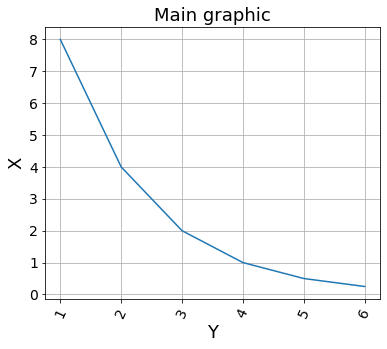

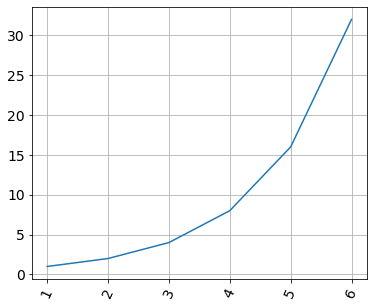

In [38]:
# Tests:

representar_xxx_yyy(
    [(1, 8), (2, 4), (3, 2), (4, 1), (5, 0.5), (6, 0.25)], 
    ["Main graphic", "X", "Y"]
)

representar_xxx_yyy(
    [(1, 1), (2, 2), (3, 4), (4, 8), (5, 16), (6, 32)], 
    []
)

**Death rate by ages** 

We are going to apply our graphic model to the deadly accident rates that we got earlier, but we are getting a graphic that is not too adequate because the ages are not sorted.

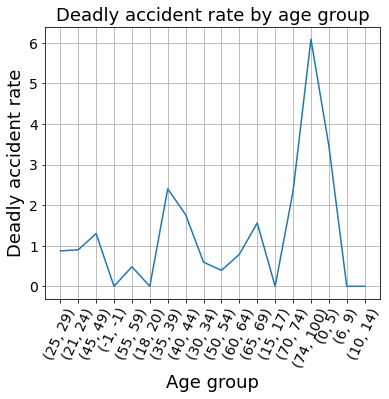

In [39]:
# Test:

rotulos = "Deadly accident rate by age group", "Deadly accident rate", "Age group"
representar_xxx_yyy(tasa_accidentes_mortales_por_mil, rotulos)

In order to solve this we have to sort the age groups (including '(-1, -1)') like this:

In [41]:
def ordenar_tasa_04(lista):
    return lista[0]

tasa_accidentes_mortales_por_mil.sort(key = ordenar_tasa_04)

tasa_accidentes_mortales_por_mil.pop(0)

((-1, -1), 0.0)

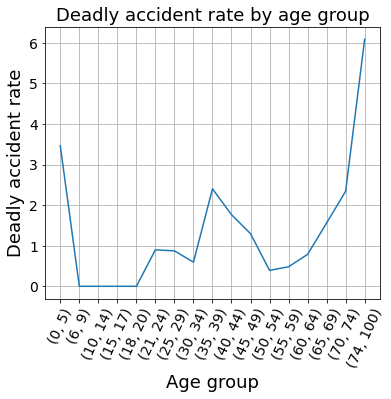

In [42]:
# Tests:

representar_xxx_yyy(tasa_accidentes_mortales_por_mil, rotulos)

**Death rate by time groups** 

Now we are going to do the same but with time groups, we are not going to take into account the minutes and we are going to group the hours by pairs.

In [43]:
def totales_mortales_por_horario(lista):
    horas = list(range(0, 24, 2))
    accidentes_hr = dict.fromkeys(horas)
    muertes_hr = dict.fromkeys(horas) 
    # Career Karma: Python Convert List to Dictionary: A Complete Guide
    
    for elem in accidentes_hr:
        accidentes_hr[elem] = 0
    
    for elem in muertes_hr:
        muertes_hr[elem] = 0
    
    for linea in lista:
        linea[0] = int(linea[0])
        # If the hour can be divided by 2 and there is death:
        if linea[0] in horas and linea[4] == 4:
            accidentes_hr[linea[0]] += 1
            muertes_hr[linea[0]] += 1
        elif linea[0] in horas:
            accidentes_hr[linea[0]] += 1
        elif linea[4] == 4:
            accidentes_hr[linea[0] - 1] += 1
            muertes_hr[linea[0] - 1] += 1
        else:
            accidentes_hr[linea[0] - 1] += 1
    
    # tasa_accidentes_mortales_por_mil = [(k, m*1000/n) for k, (n, m) in total_accidentes_y_muertes_por_edades]
    
    tasa_muertes_hr = []
    
    for elem in muertes_hr:
        tasa_muertes_hr.append(
            (
                elem,
                (muertes_hr[elem] * 1000 / accidentes_hr[elem])
            )
        )
    
    return tasa_muertes_hr
    
def emparejar_abcisas(lista):
    resultado = []
    
    for elem in lista:
        resultado.append(
            tuple([
                str(
                    tuple([ elem[0], elem[0] + 2 ])
                ),
                elem[1]
            ])
        )
    
    return resultado

[(0, 1.9230769230769231), (2, 4.178272980501393), (4, 1.949317738791423), (6, 0.8635578583765112), (8, 1.1415525114155252), (10, 1.5337423312883436), (12, 0.8234971177600878), (14, 1.112099644128114), (16, 0.5351886540005352), (18, 0.4287245444801715), (20, 1.1999040076793857), (22, 1.187178472497032)]

[('(0, 2)', 1.9230769230769231), ('(2, 4)', 4.178272980501393), ('(4, 6)', 1.949317738791423), ('(6, 8)', 0.8635578583765112), ('(8, 10)', 1.1415525114155252), ('(10, 12)', 1.5337423312883436), ('(12, 14)', 0.8234971177600878), ('(14, 16)', 1.112099644128114), ('(16, 18)', 0.5351886540005352), ('(18, 20)', 0.4287245444801715), ('(20, 22)', 1.1999040076793857), ('(22, 24)', 1.187178472497032)]


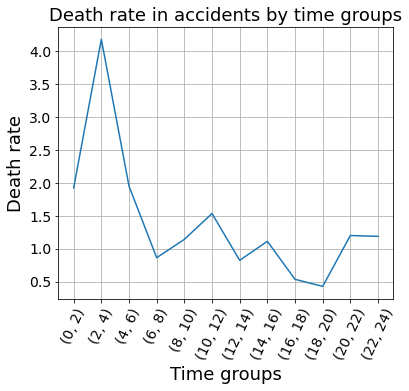

In [44]:
# Tests:

tasas_accidentes_y_muertes_por_horario = totales_mortales_por_horario(datos_lista)

print(tasas_accidentes_y_muertes_por_horario)

print()

datos_para_grafica = emparejar_abcisas(tasas_accidentes_y_muertes_por_horario)

print(datos_para_grafica)

rotulos = "Death rate in accidents by time groups", "Death rate", "Time groups"
representar_xxx_yyy(datos_para_grafica, rotulos)

## Some operations with dataframes

Now, we are going to work with the Pandas library.

**Loading the dataframe**

First we are going to load the data file into a dataframe in Python:

In [45]:
import pandas

def cargar_dataframe_v0(file):
    dataframe = pandas.read_csv(file, encoding = 'ISO-8859–1', encoding_errors = 'ignore', sep = ';')
    
    dataframe = dataframe[['HORA', 'DISTRITO', 'RANGO DE EDAD', 'LESIVIDAD*']]
    
    return dataframe


In [46]:
tabla_pre = cargar_dataframe_v0("2020_Accidentalidad.csv")
print(tabla_pre)

        HORA             DISTRITO    RANGO DE EDAD  LESIVIDAD*
0      23:15               RETIRO  DE 25 A 29 AÑOS         NaN
1      22:35      MONCLOA-ARAVACA  DE 21 A 24 AÑOS         6.0
2      20:15  FUENCARRAL-EL PARDO  DE 45 A 49 AÑOS        14.0
3      20:15  FUENCARRAL-EL PARDO  DE 25 A 29 AÑOS         7.0
4      19:45               CENTRO      DESCONOCIDA         NaN
...      ...                  ...              ...         ...
32415   0:18            CHAMARTÍN  DE 35 A 39 AÑOS         NaN
32416   0:18            CHAMARTÍN  DE 35 A 39 AÑOS         NaN
32417   0:18            CHAMARTÍN  DE 35 A 39 AÑOS         NaN
32418   0:18            CHAMARTÍN  DE 35 A 39 AÑOS         NaN
32419   0:18            CHAMARTÍN  DE 35 A 39 AÑOS         NaN

[32420 rows x 4 columns]


Now, we want to modify the data so that we can see the age groups like an interval. Also, the damage variable has been read like an int and the blank ones are now a NaN (not a number). Now this will become a 0 when we don't have any data and a 1 when there is damage. 

In [47]:
import numpy

def cargar_dataframe(file):
    dataframe = pandas.read_csv(file, encoding = 'ISO-8859–1', encoding_errors = 'ignore', sep = ';')
    
    dataframe = dataframe[['HORA', 'DISTRITO', 'RANGO DE EDAD', 'LESIVIDAD*']]
    
    for index, row in dataframe.iterrows():
        if numpy.isnan(dataframe.iloc[index][3]) or dataframe.iloc[index][3] == 14 or dataframe.iloc[index][3] == 77:
            dataframe.loc[index, 'LESIVIDAD*'] = 0
        else:
            dataframe.loc[index, 'LESIVIDAD*'] = 1
    
    dataframe['RANGO DE EDAD'] = dataframe['RANGO DE EDAD'].apply(rango_edad)
    
    dataframe['LESIVIDAD*'] = dataframe['LESIVIDAD*'].astype(int)
    
    return dataframe


In [48]:
tabla = cargar_dataframe("2020_Accidentalidad.csv")
tabla

,HORA,DISTRITO,RANGO DE EDAD,LESIVIDAD*
0,23:15,RETIRO,"(25, 29)",0
1,22:35,MONCLOA-ARAVACA,"(21, 24)",1
2,20:15,FUENCARRAL-EL PARDO,"(45, 49)",0
3,20:15,FUENCARRAL-EL PARDO,"(25, 29)",1
4,19:45,CENTRO,"(-1, -1)",0
...,...,...,...,...
32415,0:18,CHAMARTÍN,"(35, 39)",0
32416,0:18,CHAMARTÍN,"(35, 39)",0
32417,0:18,CHAMARTÍN,"(35, 39)",0
32418,0:18,CHAMARTÍN,"(35, 39)",0


**Number of accidents by age group: Table**

We are only interested in two columns: Age and Number of Accidents to make a new table.

In [49]:
tabla_conteo_por_edades = tabla.groupby('RANGO DE EDAD').count().reset_index()

tabla_conteo_por_edades = tabla_conteo_por_edades[['RANGO DE EDAD', 'LESIVIDAD*']]

tabla_conteo_por_edades = tabla_conteo_por_edades.rename(
    {'RANGO DE EDAD': 'Edad', 'LESIVIDAD*': 'NumAccs'}, axis='columns')

tabla_conteo_por_edades

,Edad,NumAccs
0,"(-1, -1)",3962
1,"(0, 5)",289
2,"(6, 9)",175
3,"(10, 14)",305
4,"(15, 17)",250
5,"(18, 20)",978
6,"(21, 24)",2226
7,"(25, 29)",3437
8,"(30, 34)",3362
9,"(35, 39)",3332


This table contains the age group '(-1, -1)', but we don't care about it, so we're going to delete it.

In [50]:
tabla_conteo_por_edades = tabla_conteo_por_edades.drop([0])

tabla_conteo_por_edades

,Edad,NumAccs
1,"(0, 5)",289
2,"(6, 9)",175
3,"(10, 14)",305
4,"(15, 17)",250
5,"(18, 20)",978
6,"(21, 24)",2226
7,"(25, 29)",3437
8,"(30, 34)",3362
9,"(35, 39)",3332
10,"(40, 44)",3399


**Accidents with medical consequences**

Now we want to know how many accidents required medical intervention or even resulted in death, per each age group.

In [51]:
tabla_conteo_por_edades_con_lesiones = tabla.groupby('RANGO DE EDAD').sum().reset_index()

tabla_conteo_por_edades_con_lesiones = tabla_conteo_por_edades_con_lesiones.rename(
    {'RANGO DE EDAD': 'Edad', 'LESIVIDAD*': 'NumAccsConLesiones'}, axis='columns')

tabla_conteo_por_edades_con_lesiones = tabla_conteo_por_edades_con_lesiones.drop([0])

tabla_conteo_por_edades_con_lesiones


,Edad,NumAccsConLesiones
1,"(0, 5)",107
2,"(6, 9)",73
3,"(10, 14)",135
4,"(15, 17)",114
5,"(18, 20)",325
6,"(21, 24)",720
7,"(25, 29)",1184
8,"(30, 34)",1098
9,"(35, 39)",944
10,"(40, 44)",899


**Union of two tables**

Now we wish to combine the two tables using the Age variable as a reference, like the 'Inner Join' operation in SQL.

In [52]:
frame = [tabla_conteo_por_edades_con_lesiones, tabla_conteo_por_edades]

tabla_joined = pandas.merge(
    tabla_conteo_por_edades,
    tabla_conteo_por_edades_con_lesiones,
)

tabla_joined

,Edad,NumAccs,NumAccsConLesiones
0,"(0, 5)",289,107
1,"(6, 9)",175,73
2,"(10, 14)",305,135
3,"(15, 17)",250,114
4,"(18, 20)",978,325
5,"(21, 24)",2226,720
6,"(25, 29)",3437,1184
7,"(30, 34)",3362,1098
8,"(35, 39)",3332,944
9,"(40, 44)",3399,899


**Accidents with damage proportion**

Now we are going to generate another column making a calculation with the data in the existing columns.

In [53]:
tabla_joined_prop = tabla_joined

tabla_joined_prop['PropLesiones'] = (tabla_joined_prop.NumAccsConLesiones / tabla_joined_prop.NumAccs) * 100

tabla_joined_prop

,Edad,NumAccs,NumAccsConLesiones,PropLesiones
0,"(0, 5)",289,107,37.024221
1,"(6, 9)",175,73,41.714286
2,"(10, 14)",305,135,44.262295
3,"(15, 17)",250,114,45.600000
4,"(18, 20)",978,325,33.231084
5,"(21, 24)",2226,720,32.345013
6,"(25, 29)",3437,1184,34.448647
7,"(30, 34)",3362,1098,32.659131
8,"(35, 39)",3332,944,28.331333
9,"(40, 44)",3399,899,26.448956


**Graph**

Now we are going to represent this in a graph:

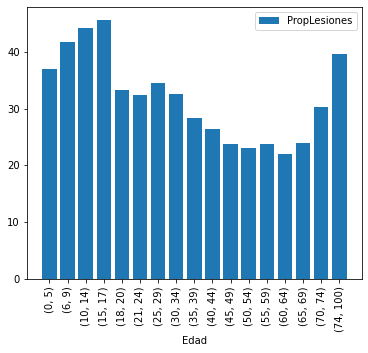

In [55]:
tabla_joined_prop_plt = tabla_joined_prop

tabla_joined_prop_plt['Edad'] = tabla_joined_prop_plt['Edad'].apply(str)

import matplotlib.pyplot as plt

rangos = list(tabla_joined_prop_plt['Edad'])
porcentajes = list(tabla_joined_prop_plt['PropLesiones'])

ypos = numpy.arange(len(rangos))

plt.xticks(ypos, rangos, rotation = 90)
plt.xlabel('Edad')
plt.bar(ypos, porcentajes, label = 'PropLesiones')
plt.legend()

plt.show()